# Pipeline

Objectif : Faire de la classification de sentiment via des RNN avec tensorflow 2
Nous allons reprendre le tp d'hier et nous allons utiliser les RNN à la place des CNN. L'objectif est notammenet de comparer les deux approches.

Vous devez avoir l'habitude du déroulement maintenant :
1. Charger les données
2. Préprocesser les données. 
3. Créer un modèle avec des RNN (embedding -> couches RNN et compagnie -> flatten -> couches denses et compagnie -> sortie
4. Compiler le modèle (choisir loss, optimizer, etc.):
5. Entrainer et evaluer les performances

Dans ce tp vous allez réaliser plusieurs itérations. Munissez vous de votre plus joli fichier Excel et marquez les performances de vos itérations !
Dans les itérations, testez dans cet ordre :
1.  Utilisation des LSTM (réseau de taille petite, pour tester)
1. bis Utilisation des LSTM (réseau plus conséquent)
2. bis Utilisation des GRU (réseau plus conséquent, identique 1 bis)
3. bis Utilisation des bidirectionnal LSTM (réseau plus conséquent, identique 1 bis)
4. Modifiez directement la méthode d'embedding de keras pour vous appuyer sur un embedding généré par un word2vec déjà entraîné. Pour ne pas rendre les Wps trop lourdes, appuyez vous sur une taille de vecteur de 50 ou 100. Puis répétez les itérations 1,2 et 3.

# Import 

In [1]:
# import the necessary packages
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # if you have an other omp process running 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, GlobalAvgPool1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import numpy as np
import time
import sys
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt


# Load Data

- Dataset imdb 

In [2]:
max_features = 5000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')


Loading data...
17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences


In [3]:
# Use the default parameters to keras.datasets.imdb.load_data
start_char = 1
oov_char = 2
index_from = 3
word_index = imdb.get_word_index()
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"
# Decode the first sequence in the dataset
def decode_dataset(dataset, index):
    return " ".join(inverted_word_index[i] for i in dataset[index])

1641221/1641221 [==============================] - 0s 0us/step


In [4]:
x_train[1]

[1,
 194,
 1153,
 194,
 2,
 78,
 228,
 5,
 6,
 1463,
 4369,
 2,
 134,
 26,
 4,
 715,
 8,
 118,
 1634,
 14,
 394,
 20,
 13,
 119,
 954,
 189,
 102,
 5,
 207,
 110,
 3103,
 21,
 14,
 69,
 188,
 8,
 30,
 23,
 7,
 4,
 249,
 126,
 93,
 4,
 114,
 9,
 2300,
 1523,
 5,
 647,
 4,
 116,
 9,
 35,
 2,
 4,
 229,
 9,
 340,
 1322,
 4,
 118,
 9,
 4,
 130,
 4901,
 19,
 4,
 1002,
 5,
 89,
 29,
 952,
 46,
 37,
 4,
 455,
 9,
 45,
 43,
 38,
 1543,
 1905,
 398,
 4,
 1649,
 26,
 2,
 5,
 163,
 11,
 3215,
 2,
 4,
 1153,
 9,
 194,
 775,
 7,
 2,
 2,
 349,
 2637,
 148,
 605,
 2,
 2,
 15,
 123,
 125,
 68,
 2,
 2,
 15,
 349,
 165,
 4362,
 98,
 5,
 4,
 228,
 9,
 43,
 2,
 1157,
 15,
 299,
 120,
 5,
 120,
 174,
 11,
 220,
 175,
 136,
 50,
 9,
 4373,
 228,
 2,
 5,
 2,
 656,
 245,
 2350,
 5,
 4,
 2,
 131,
 152,
 491,
 18,
 2,
 32,
 2,
 1212,
 14,
 9,
 6,
 371,
 78,
 22,
 625,
 64,
 1382,
 9,
 8,
 168,
 145,
 23,
 4,
 1690,
 15,
 16,
 4,
 1355,
 5,
 28,
 6,
 52,
 154,
 462,
 33,
 89,
 78,
 285,
 16,
 145,
 95]

In [5]:
decode_dataset(x_train, 1)

"[START] big hair big [OOV] bad music and a giant safety [OOV] these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an [OOV] the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are [OOV] and funny in equal [OOV] the hair is big lots of [OOV] [OOV] men wear those cut [OOV] [OOV] that show off their [OOV] [OOV] that men actually wore them and the music is just [OOV] trash that plays over and over again in almost every scene there is trashy music [OOV] and [OOV] taking away bodies and the [OOV] still doesn't close for [OOV] all [OOV] aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

# Utility methods for data manipulation

Les tokens 0-3 ont un sens particulier dans IMDB.

In [6]:
label_to_text = ["Negative sentiment","Positive sentiment"]
index = imdb.get_word_index()

id_to_word = {(v+3):k for k,v in index.items()}
id_to_word[0] = "<PAD>"
id_to_word[1] = "<START>"
id_to_word[2] = "<UNK>"
id_to_word[3] = "<UNUSED>"

def sample_to_string(sample):
    return " ".join([id_to_word[word] for word in sample])

## Let's explore the data

- labels

combien y a-t-il de categories possibles ? sont-elles bien réparties ?

In [7]:
# TODO
print(f"Il y a {len(np.unique(y_test))} categories possibles : {label_to_text}")

Il y a 2 categories possibles : ['Negative sentiment', 'Positive sentiment']


In [8]:
print(f"Il y a {sum(y_test)/y_test.size} % de {label_to_text[1]}")

Il y a 0.5 % de Positive sentiment


- data

Que contient un echantillon ? Combien de mots contiennent les textes ?

In [9]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 2,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 2,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 2,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 2,
 18,
 51,
 36,
 

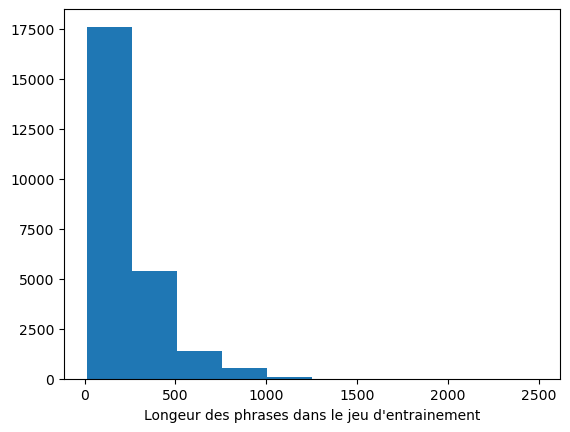

In [10]:
plt.hist([len(col) for col in x_train])
plt.xlabel("Longeur des phrases dans le jeu d'entrainement")
plt.show()

# Preprocessing 

- Toutes nos entrées doivent avoir la même taille. Solution ? padding des phrases trop courtes, tronquer (améliorable) les phrases trop longues.
- on peut le faire en entrée du réseau
- ou en preprocessing avant de fournir l'entrée au réseau, ce qui évite d'avoir à refaire la conversion a chaque epoque

In [11]:
# cut texts after this number of words
maxlen = 150

print('Pad sequences (samples x time)')
# TODO : padding : put all the sentences of x_train and x_test to maxlen tokens.
x_train_pad = np.zeros((25000,maxlen), int)
for i, sentence in enumerate(x_train):
    x_train_pad[i,:min(len(sentence),maxlen)] = sentence[:min(len(sentence),maxlen)]
x_test_pad = np.zeros((25000,maxlen), int)
for i, sentence in enumerate(x_test):
    x_test_pad[i,:min(len(sentence),maxlen)] = sentence[:min(len(sentence),maxlen)]
print('x_train shape:', x_train_pad.shape)
print('x_test shape:', x_test_pad.shape)

Pad sequences (samples x time)
x_train shape: (25000, 150)
x_test shape: (25000, 150)


Let's verify:

In [12]:
print(x_train_pad[0])
print(len(x_train[0]))

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
    2   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117    2   15  256
    4    2    7 3766    5  723   36   71   43  530]
218


# Modeling

Comme d'habitude, commencez par une architecture et un entrainement très simple, puis complexifiez

In [13]:
def build_model():
    embedding_dim = 50
    model = Sequential()
    # TODO : model

    return model

In [14]:
print("[INFO] creating model...")
model = build_model()

model.compile()

[INFO] creating model...


# Fit

In [15]:
# For tensorboard
os.makedirs("./logs",exist_ok=True)
tensorboard = TensorBoard(log_dir=os.path.join('./logs'), histogram_freq=0,
                              write_graph=True, write_images=False,profile_batch = 100000000)

callbacks = [tensorboard]
model.fit()

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           4429200   
                                                                 
 conv1d (Conv1D)             (None, 148, 32)           4832      
                                                                 
 flatten (Flatten)           (None, 4736)              0         
                                                                 
 dense (Dense)               (None, 100)               473700    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 4,907,833
Trainable params: 4,907,833
Non-trainable params: 0
_________________________________________________________________


# Evaluation

In [25]:
# rajouter la metrique lors de la compilation pour l'avoir via evaluate. 
# model.compile(optimizer=opt, loss=binary_crossentropy, metrics=["acc"]) 
#  Sinon, utilisez predict et la metrique de scikit

(loss, acc) = model.evaluate(x_test_pad, y_test)
print(f"[INFO] test accuracy: {acc}")

782/782 [==============================] - 2s 3ms/step - loss: 0.9679 - acc: 0.8124
[INFO] test accuracy: 0.8124399781227112


In [26]:
model.predict(x_test_pad[1:100])

array([[1.00000000e+00],
       [9.89548922e-01],
       [8.62614095e-01],
       [9.98754621e-01],
       [1.80813372e-02],
       [6.45670414e-01],
       [3.19765590e-12],
       [1.00000000e+00],
       [4.61726559e-05],
       [9.99870360e-01],
       [1.57687700e-11],
       [4.83194307e-15],
       [1.67220831e-04],
       [1.00000000e+00],
       [1.23268388e-12],
       [9.99933124e-01],
       [9.96217549e-01],
       [2.67035971e-09],
       [2.96666658e-05],
       [9.99999642e-01],
       [1.00000000e+00],
       [6.07707083e-01],
       [1.00000000e+00],
       [9.90126848e-01],
       [8.33236814e-01],
       [2.37506628e-03],
       [9.53127682e-01],
       [1.00000000e+00],
       [1.94414085e-14],
       [1.00000000e+00],
       [9.69300866e-01],
       [9.99879897e-01],
       [1.56166479e-07],
       [1.32815190e-08],
       [1.19962762e-10],
       [9.99999762e-01],
       [9.99998927e-01],
       [9.32140119e-06],
       [2.01547695e-10],
       [9.99998450e-01],


- analyser les erreurs que fait votre modele
- fait il de l'overfitting ? de l'underfitting ?
- essayer incrémentalement d'augmenter ses performances suivant les erreurs constatées.
- utiliser tensorboard pour mieux comprendre ce qu'il se passe durant l'entrainement